In [ ]:
#| default_exp jacobians

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import torch
from diffdrr.pose import convert


class JacobianDRR(torch.nn.Module):
    """Computes the Jacobian of a DRR wrt pose parameters."""

    def __init__(
        self,
        drr,
        rotation,
        translation,
        parameterization,
        convention=None,
    ):
        super().__init__()
        self.drr = drr
        self.rotation = torch.nn.Parameter(rotation.clone())
        self.translation = torch.nn.Parameter(translation.clone())
        self.parameterization = parameterization
        self.convention = convention

    def forward(self):
        I = self.cast(self.rotation, self.translation)
        J = torch.autograd.functional.jacobian(
            self.cast,
            (self.rotation, self.translation),
            vectorize=True,
            strategy="forward-mode",
        )
        J = torch.concat([self.permute(j) for j in J], dim=0)
        return I, J

    def cast(self, rotation, translation):
        pose = convert(
            rotation,
            translation,
            parameterization=self.parameterization,
            convention=self.convention,
        )
        return self.drr(pose)

    def permute(self, x):
        return x.permute(-1, 0, 2, 3, 1, 4)[..., 0, 0]

In [ ]:
#| export
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def plot_img_jacobian(I, J, **kwargs):
    def fmt(x, pos):
        a, b = f"{x:.0e}".split("e")
        a = float(a)
        b = int(b)
        if a == 0:
            return "0"
        elif b == 0:
            if a < 0:
                return "-1"
            else:
                return "1"
        elif a < 0:
            return rf"$-10^{{{b}}}$"
        else:
            return rf"$10^{{{b}}}$"

    plt.figure(figsize=(10, 4), dpi=300, constrained_layout=True)
    plt.subplot(2, 4, 2)
    plt.title("J(yaw)")
    plt.imshow(J[0].squeeze().cpu().detach(), **kwargs)
    plt.colorbar(format=FuncFormatter(fmt))
    plt.axis("off")
    plt.subplot(2, 4, 3)
    plt.title("J(pitch)")
    plt.imshow(J[1].squeeze().cpu().detach(), **kwargs)
    plt.colorbar(format=FuncFormatter(fmt))
    plt.axis("off")
    plt.subplot(2, 4, 4)
    plt.title("J(roll)")
    plt.imshow(J[2].squeeze().cpu().detach(), **kwargs)
    plt.colorbar(format=FuncFormatter(fmt))
    plt.axis("off")
    plt.subplot(2, 4, 6)
    plt.title("J(x)")
    plt.imshow(J[3].squeeze().cpu().detach(), **kwargs)
    plt.colorbar(format=FuncFormatter(fmt))
    plt.axis("off")
    plt.subplot(2, 4, 7)
    plt.title("J(y)")
    plt.imshow(J[4].squeeze().cpu().detach(), **kwargs)
    plt.colorbar(format=FuncFormatter(fmt))
    plt.axis("off")
    plt.subplot(2, 4, 8)
    plt.title("J(z)")
    plt.imshow(J[5].squeeze().cpu().detach(), **kwargs)
    plt.colorbar(format=FuncFormatter(fmt))
    plt.axis("off")
    plt.subplot(2, 4, 1)
    plt.title("img")
    plt.imshow(I.cpu().detach().squeeze(), cmap="gray")
    plt.axis("off")
    plt.colorbar()
    plt.show()

In [ ]:
#| export
def preconditioner(jacobian, p=-0.5, λ=1e-1, μ=1e-8):
    """Calculate the inverse preconditioning matrix."""
    # Calculate the covariance matrix
    vecj = jacobian.flatten(start_dim=1)
    cov = vecj @ vecj.T

    # Apply a small dampening parameter
    eyelike = lambda A: torch.eye(A.shape[0]).to(A)
    cov += λ * torch.diag(torch.diag(cov)) + μ * eyelike(cov)

    # Calculate the preconditioning matrix
    eigenvalues, V = torch.linalg.eigh(cov)
    Dexp = torch.diag(eigenvalues.pow(p))
    return V @ Dexp @ V.T

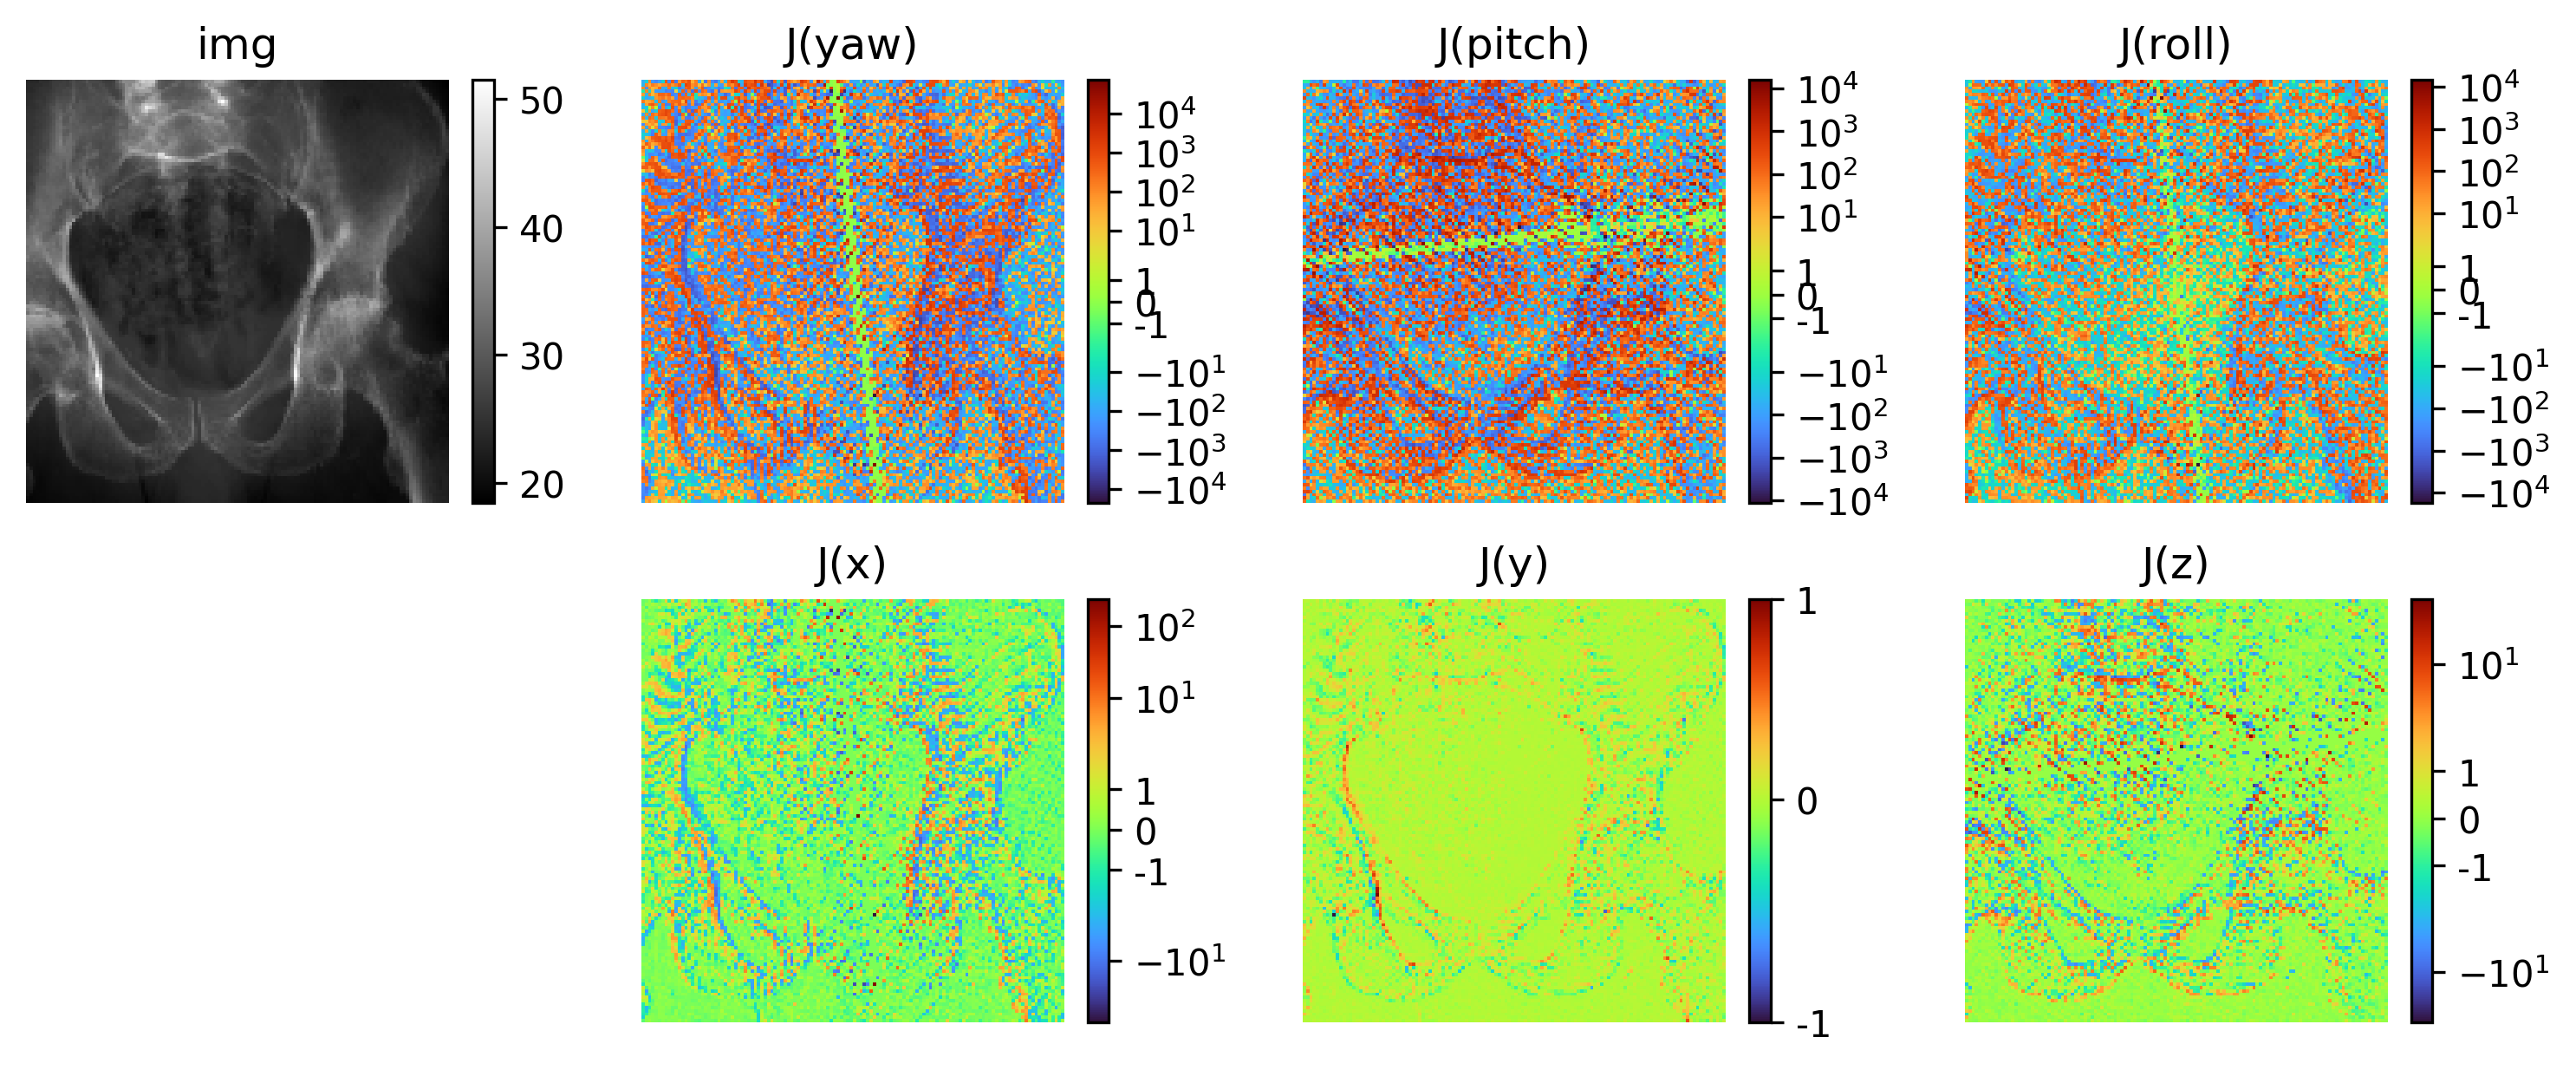

In [ ]:
#| eval: false
from diffdrr.drr import DRR

from diffpose.deepfluoro import DeepFluoroDataset

device = torch.device("cuda")

specimen = DeepFluoroDataset(id_number=1)
height = 128
subsample = (1536 - 100) / height
delx = 0.194 * subsample

drr = DRR(
    specimen.volume,
    specimen.spacing,
    sdr=specimen.focal_len / 2,
    height=height,
    delx=delx,
    x0=specimen.x0,
    y0=specimen.y0,
    reverse_x_axis=True,
    bone_attenuation_multiplier=2.5,
).to(device)

_, pose = specimen[52]
R, t = pose.convert("euler_angles", convention="ZYX")
R, t = R.to(device), t.to(device)

jacdrr = JacobianDRR(drr, R, t, "euler_angles", "ZYX")
I0, J0 = jacdrr()

kwargs = dict(cmap="turbo", norm="symlog")
plot_img_jacobian(I0, J0, **kwargs)

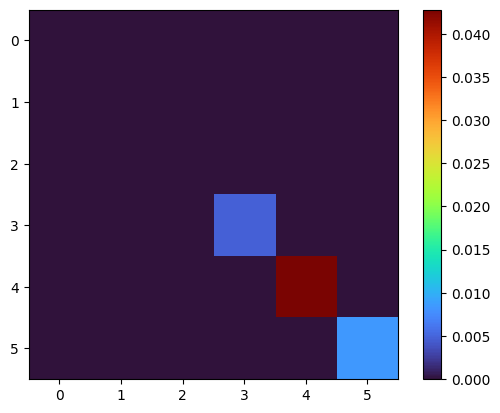

In [ ]:
#| eval: false
plt.imshow(preconditioner(J0).cpu().detach(), cmap="turbo")
plt.colorbar()
plt.show()

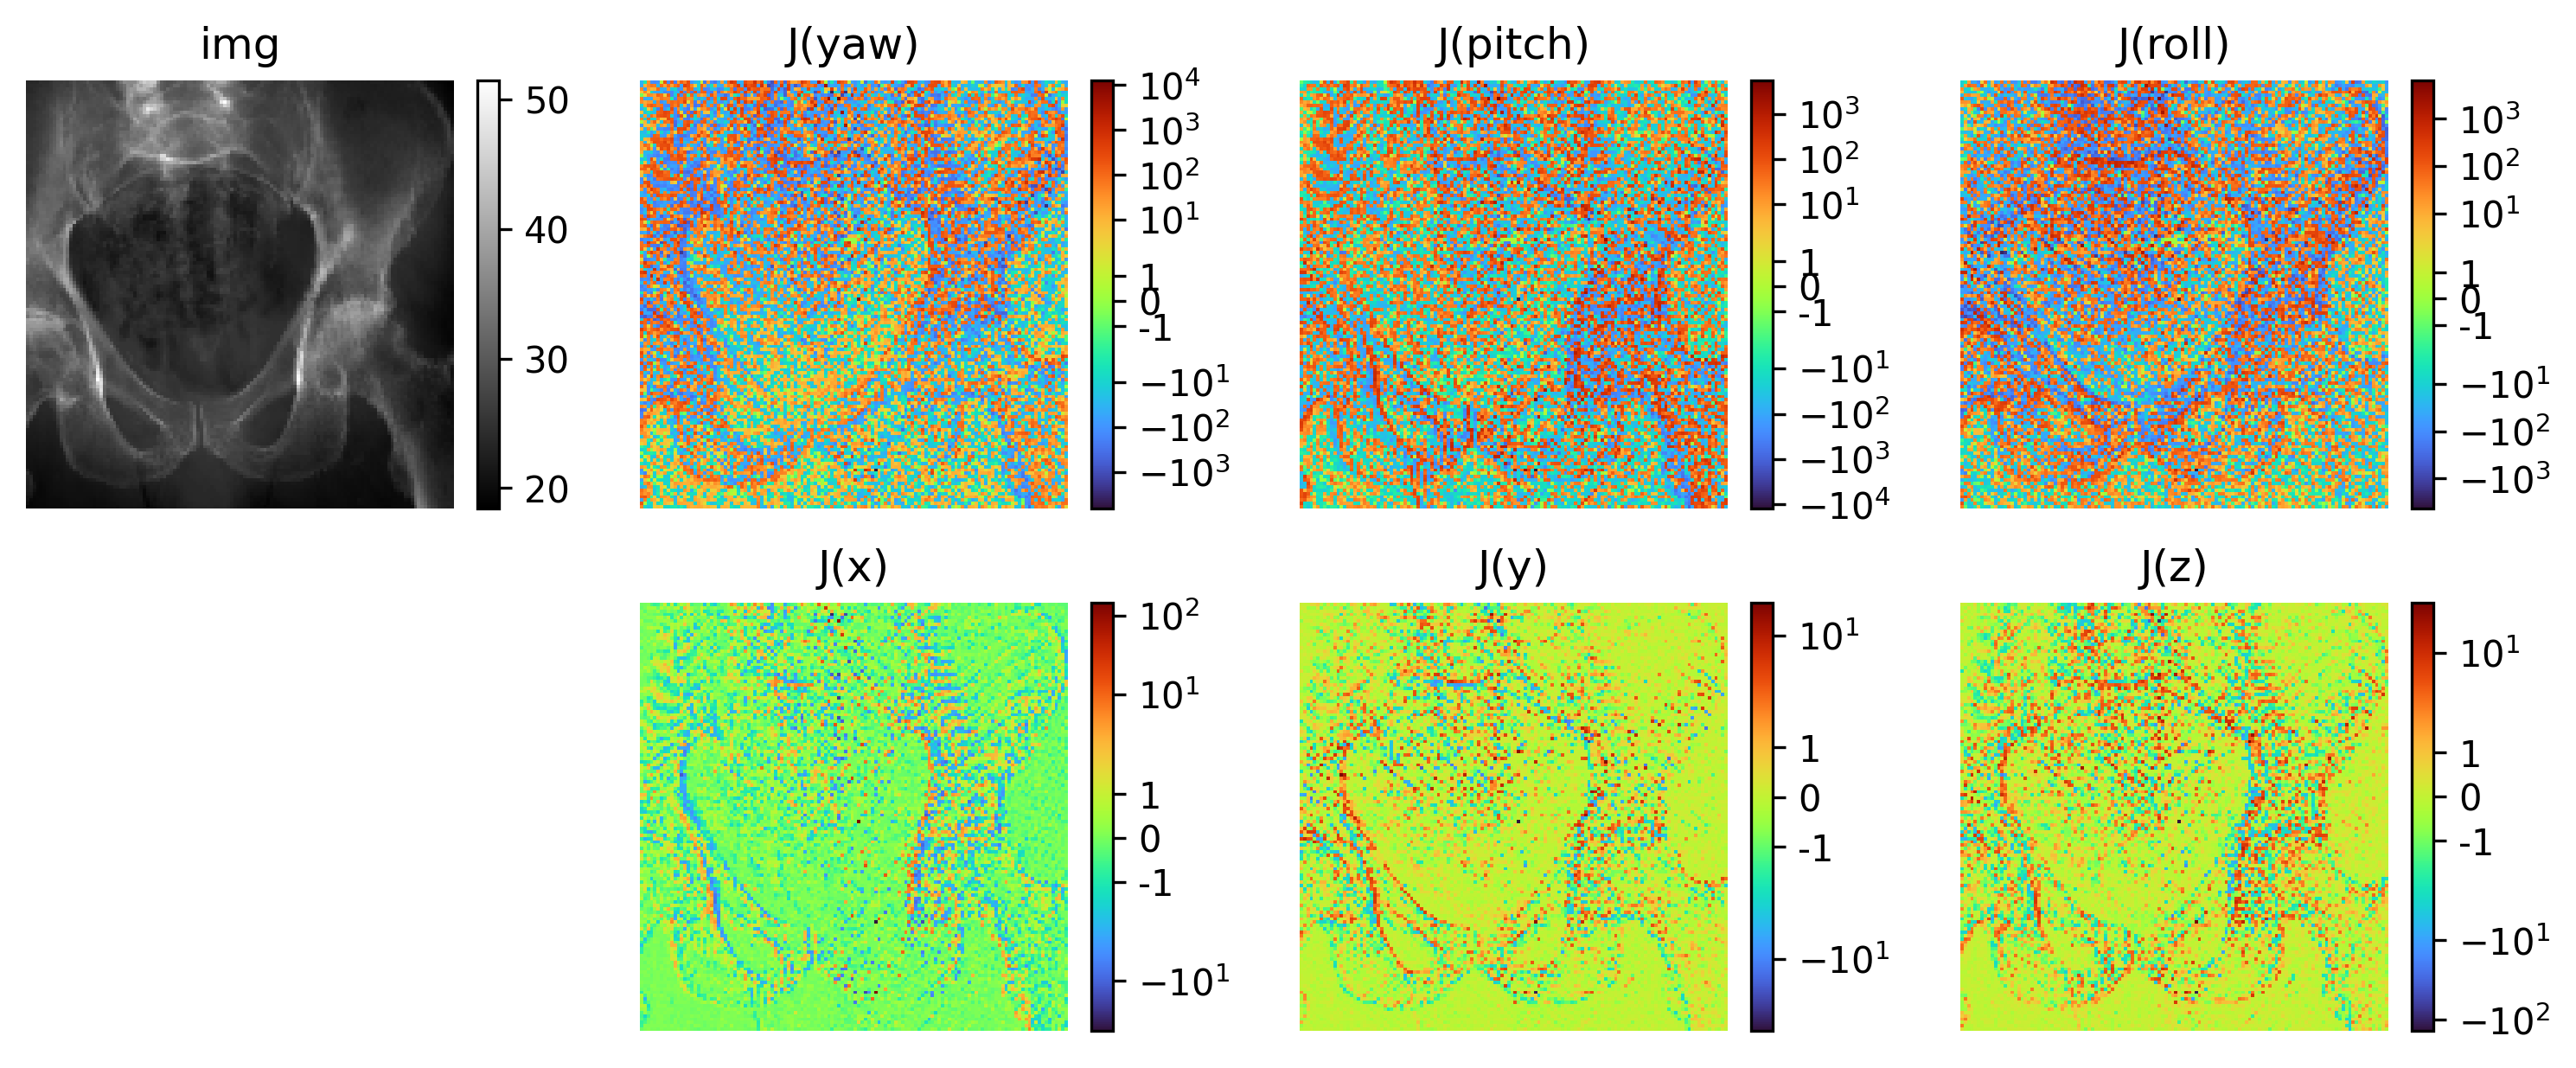

In [ ]:
#| eval: false
_, pose = specimen[52]
R, t = pose.convert("se3_log_map")
R, t = R.to(device), t.to(device)

jacdrr = JacobianDRR(drr, R, t, "se3_log_map")
I0, J0 = jacdrr()

kwargs = dict(cmap="turbo", norm="symlog")
plot_img_jacobian(I0, J0, **kwargs)

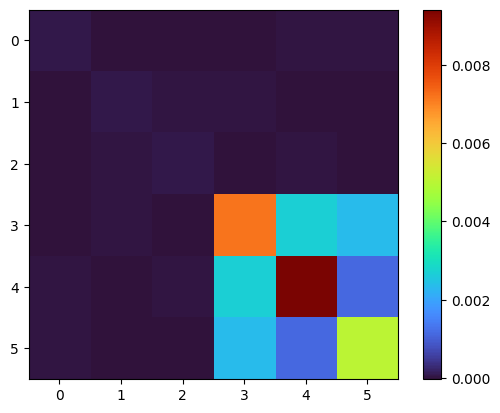

In [ ]:
#| eval: false
plt.imshow(preconditioner(J0).cpu().detach(), cmap="turbo")
plt.colorbar()
plt.show()

In [ ]:
class PreconditionedDRR(torch.nn.Module):
    """Computes the Jacobian of a DRR wrt pose parameters."""

    def __init__(
        self,
        drr,
        pinv,
        rotation,
        translation,
        parameterization,
        convention=None,
    ):
        super().__init__()
        self.drr = drr
        self.pinv = pinv
        self.parameterization = parameterization
        self.convention = convention

        camera_params = torch.concat([rotation.clone(), translation.clone()], dim=1)
        camera_params = torch.einsum("ij, bj -> bi", pinv.inverse(), camera_params)
        self.camera_params = torch.nn.Parameter(camera_params)

    def forward(self):
        params = torch.einsum("ij, bj -> bi", self.pinv, self.camera_params)
        R, t = params[..., :3], params[..., 3:]
        pose = convert(
            R, t, parameterization=self.parameterization, convention=self.convention
        )
        return self.drr(pose)

In [ ]:
from diffdrr.visualization import plot_drr

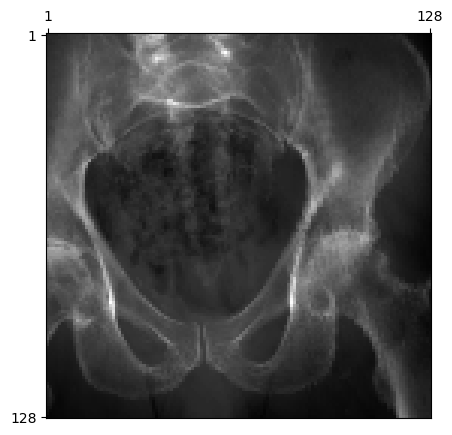

In [ ]:
#| eval: false
pinv = preconditioner(J0)
predrr = PreconditionedDRR(drr, pinv, R, t, "se3_log_map")

plot_drr(predrr())
plt.show()

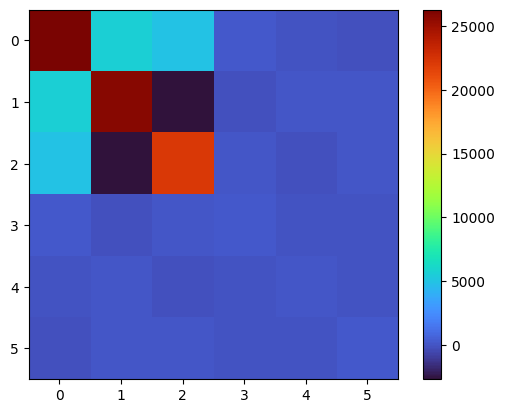

In [ ]:
plt.imshow(pinv.inverse().cpu().detach(), cmap="turbo")
plt.colorbar()
plt.show()

In [ ]:
#| eval: false
_, pose = specimen[52]
R, t = pose.convert("euler_angles", convention="ZYX")
R, t = R.to(device), t.to(device)

In [ ]:
#| eval: false
def jacobian(rotation, translation, parameterization, convention=None):
    J = torch.autograd.functional.jacobian(
        lambda R, t: drr.forward(
            R,
            t,
            parameterization=parameterization,
            convention=convention,
        ),
        (R, t),
        vectorize=True,
        strategy="forward-mode",
    )
    J = torch.concat([j.permute(-1, 0, 2, 3, 1, 4)[..., 0, 0] for j in J], dim=0)
    return J

In [ ]:
#| eval: false
J = jacobian(R, t, "se3_log_map")
J.shape

torch.Size([6, 1, 128, 128])

In [ ]:
#| eval: false
P = preconditioner(J)
P.shape

torch.Size([6, 6])

In [ ]:
def jacobian(drr, rotation, translation, parameterization, convention=None):
    J = torch.autograd.functional.jacobian(
        lambda rotation, translation: drr.forward(convert(R, t, parameterization=parameterization)),
        (rotation, translation),
        vectorize=True,
        strategy="forward-mode",
    )
    J = torch.concat([j.permute(-1, 0, 2, 3, 1, 4)[..., 0, 0] for j in J], dim=0)
    return J


def preconditioner(jacobian, p=-0.5, λ=1e-1, μ=1e-8):
    """Calculate the inverse preconditioning matrix."""
    # Calculate the covariance matrix
    vecj = jacobian.flatten(start_dim=1)
    cov = vecj @ vecj.T

    # Apply a small dampening parameter
    eyelike = lambda A: torch.eye(A.shape[0]).to(A)
    cov += λ * torch.diag(torch.diag(cov)) + μ * eyelike(cov)

    # Calculate the preconditioning matrix
    eigenvalues, V = torch.linalg.eigh(cov)
    Dexp = torch.diag(eigenvalues.pow(p))
    return V @ Dexp @ V.T

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()